In [4]:
import numpy as np

from numpy.testing import assert_allclose

# QR decomposition

Any real $m \times n$ matrix can be decomposed into 
$$\mathbf{A} = \mathbf{Q} \cdot \mathbf{R}, $$
where $\mathbf{Q}$ is an $m \times m$ orthogonal matrix ($\mathbf{Q}^T \mathbf{Q} = \mathbf{1}$, here $\mathbf{1}$ is an identity matrix) and $\mathbf{R}$ is an $m \times n$ upper triangular matrix.

If $m > n$
$$\mathbf{A} = \mathbf{Q} \begin{pmatrix}
            \mathbf{R_1} \\
            \mathbf{0}
        \end{pmatrix} = 
        \begin{pmatrix}
            \mathbf{Q_1} & \mathbf{Q_2}\\ 
        \end{pmatrix}
      \begin{pmatrix}
            \mathbf{R_1} \\
            \mathbf{0}
       \end{pmatrix} = \mathbf{Q_1} \mathbf{R_1},$$
where $\mathbf{R_1}$ is $m \times m$ upper triangular, $\mathbf{Q_1}$ is $m \times n$ matrix and has orthonormal columns. This operation is called *thin QR* (*reduced*) factorization. 

If columns of $\mathbf{A}$ are linearly independent, then
1. The thin factorization $\mathbf{A} = \mathbf{Q_1} \mathbf{R_1}$ is unique;
2. Diagonal elements of $\mathbf{R_1}$ are positive.

One way to reduce $\mathbf{A}$ to $\mathbf{R}$ and construct $\mathbf{Q}$ is to implement Householder reflection algorithm column by column.

## Part I. Construct a Householder reflection of a vector.

Given a vector $\mathbf{x}$, and a plane with a normal vector $\mathbf{u}$, the Householder transformation reflects $\mathbf{x}$ about the plane.

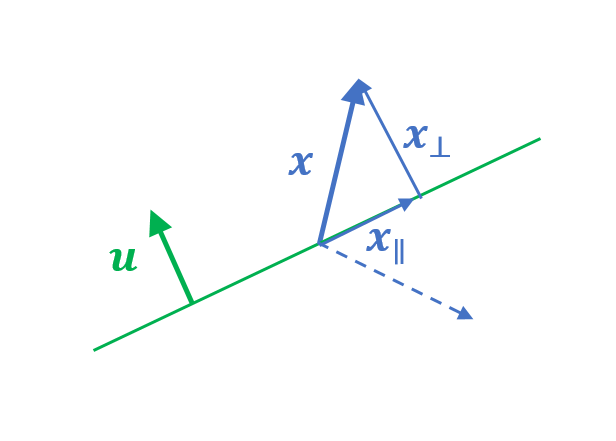

In [5]:
from IPython.display import Image
Image("pic1.png")

The matrix of the Householder transformation is
$$
\mathbf{H} = \mathbf{1} - 2 \mathbf{u} \mathbf{u}^T.
$$
Note that $H$ is symmetric and orthogonal.

Given two equal-length vectors $\mathbf{x}$ and $\mathbf{y}$, a rotation which brings $\mathbf{x}$ to $\mathbf{y}$ is a Householder transform with

$$
\mathbf{u} = \frac{\mathbf{x} - \mathbf{y}}{||\mathbf{x} - \mathbf{y}||}
$$

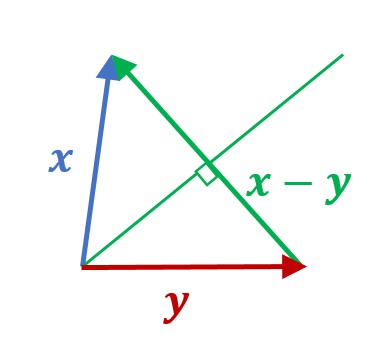

In [11]:
Image("pic2.png")

Write a function which rotates a given vector, 
$$\mathbf{x} = 
      \begin{pmatrix}
            x_1 \\
            x_2 \\
            \vdots \\
            x_n
       \end{pmatrix} \;\; \mbox{into} \;\; \mathbf{y} = 
      \begin{pmatrix}
            ||\mathbf{x}|| \\
            0 \\
            \vdots \\
            0
       \end{pmatrix}$$ 
using a Householder transformation.

In [28]:
def householder(vec):
    """Construct a Householder reflection to zero out 2nd and further components of a vector.

    Parameters
    ----------
    vec : array-like of floats, shape (n,)
        Input vector
    
    Returns
    -------
    outvec : array of floats, shape (n,)
        Transformed vector, with ``outvec[1:]==0`` and ``|outvec| == |vec|``
    H : array of floats, shape (n, n)
        Orthogonal matrix of the Householder reflection
    """
    vec = np.asarray(vec, dtype=float)
    if vec.ndim != 1:
        raise ValueError("vec.ndim = %s, expected 1" % vec.ndim)
    n = len(vec)
    I = np.eye(n)
    outvec = np.asarray(([0.0] * n), dtype = float)                                                       
    outvec[0] = np.sqrt(np.sum(np.square(vec)))
    u = np.true_divide((vec - outvec),(np.sqrt(np.sum(np.square(vec - outvec)))))    
    H = I - 2 * u * u.reshape(-1,1)
    return outvec, H


Test your function using tests below:

In [30]:
# Test I.1

v = np.array([1., 2., 3.])
v1, h = householder(v)
print(v1, h)
assert_allclose(np.dot(h, v1), v)
assert_allclose(np.dot(h, v), v1)

[3.74165739 0.         0.        ] [[ 0.26726124  0.53452248  0.80178373]
 [ 0.53452248  0.61007346 -0.5848898 ]
 [ 0.80178373 -0.5848898   0.12266529]]


AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

(mismatch 33.33333333333333%)
 x: array([ 3.741657e+00,  0.000000e+00, -1.110223e-16])
 y: array([3.741657, 0.      , 0.      ])

In [37]:
# Test I.2

rndm = np.random.RandomState(1234)

vec = rndm.uniform(size=7)
v1, h = householder(vec)
print(np.dot(h, v1))
print(vec)
assert_allclose(np.dot(h, v1), vec)

[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581 0.27259261
 0.27646426]
[0.19151945 0.62210877 0.43772774 0.78535858 0.77997581 0.27259261
 0.27646426]


In [42]:
print(np.sum(h))

4.779902562577459


See how many tests (there are 2 of them - I.1 and I.2) your function passed. Sum diagonal elements in matrix `h`. You will need this for Google Form.

## Part II. Compute the $\mathrm{QR}$ decomposition of a matrix.

Given a rectangular $m\times n$ matrix $\mathbf{A}$, construct a Householder reflector matrix $\mathbf{H}_1$ which transforms the first column of $\mathbf{A}$ (and call the result $\mathbf{A}^{(1)}$)

$$
\mathbf{H}_1 \mathbf{A} =%
\begin{pmatrix}
\times & \times & \times & \dots & \times \\
0      & \times & \times & \dots & \times \\
0      & \times & \times & \dots & \times \\
&& \dots&& \\
0      & \times & \times & \dots & \times \\
\end{pmatrix}%
\equiv \mathbf{A}^{(1)}\;.
$$

Now consider the lower-right submatrix of $\mathbf{A}^{(1)}$, and construct a Householder reflector which annihilates the second column of $\mathbf{A}$:

$$
\mathbf{H}_2 \mathbf{A}^{(1)} =%
\begin{pmatrix}
\times & \times & \times & \dots & \times \\
0      & \times & \times & \dots & \times \\
0      & 0      & \times & \dots & \times \\
&& \dots&& \\
0      & 0      & \times & \dots & \times \\
\end{pmatrix}%
\equiv \mathbf{A}^{(2)} \;.
$$

Repeating the process $n-1$ times, we obtain

$$
\mathbf{H}_{n-1} \cdots \mathbf{H}_2 \mathbf{H}_1 \mathbf{A} = \mathbf{R} \;,
$$

with $\mathbf{R}$ an upper triangular matrix. Since each $\mathbf{H}_k$ is orthogonal, so is their product. The inverse of an orthogonal matrix is orthogonal. Hence the process generates the $\mathrm{QR}$ decomposition of $\mathbf{A}$. 

Write a function, which receives a recangular matrix, $A$, and returns the Q and R factors of the $QR$ factorization of $A$.

In [63]:
def qr_decomp(a):
    """Compute the QR decomposition of a matrix.
    
    Parameters
    ----------
    a : ndarray, shape(m, n)
        The input matrix
    
    Returns
    -------
    q : ndarray, shape(m, m)
        The orthogonal matrix
    r : ndarray, shape(m, n)
        The upper triangular matrix
        
    Examples
    --------
    >>> a = np.random.random(size=(3, 5))
    >>> q, r = qr_decomp(a)
    >>> np.assert_allclose(np.dot(q, r), a)
    
    """
    a1 = np.array(a, copy=True, dtype=float)
    m, n = a1.shape
    H = np.zeros((m,m))
    r = a1
    Q = np.eye(m,m)    
    for i in range(n):
        q_i = np.eye(m, m)
        a_i = r[i:, i:]
        vec = np.array(a1[i:, i])
        outvec, h = householder(vec)
        r[i:, i:] = h @ a_i
        q_i[i:m, i:m] = h
        Q = Q @ q_i
    return Q, r
    


In [53]:
# Might want to turn this on for prettier printing: zeros instead of `1e-16` etc

np.set_printoptions(suppress=True)

In [64]:
# Test II.1

rndm = np.random.RandomState(1234)
a = rndm.uniform(size=(5, 3))
q, r = qr_decomp(a)

# test that Q is indeed orthogonal
assert_allclose(np.dot(q, q.T), np.eye(5), atol=1e-10)

# test the decomposition itself
assert_allclose(np.dot(q, r), a)


Now compare your decompositions to the library function (which actually wraps the corresponding LAPACK functions).

In [65]:
# Test II.2

from scipy.linalg import qr
qq, rr = qr(a)

assert_allclose(np.dot(qq, rr), a)
assert_allclose(qq, q)
assert_allclose(rr, r)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

(mismatch 80.0%)
 x: array([[-0.13665 ,  0.536013,  0.093698,  0.661619, -0.497491],
       [-0.560359,  0.09354 ,  0.533269, -0.524772, -0.342763],
       [-0.197259,  0.659489, -0.600685, -0.37879 ,  0.147848],...
 y: array([[ 0.13665 ,  0.536013, -0.093698,  0.769714,  0.304596],
       [ 0.560359,  0.09354 , -0.533269,  0.018395, -0.626525],
       [ 0.197259,  0.659489,  0.600685, -0.323847, -0.245895],...

Did `q` and `r` agree with `qq` and `rr`? If not, explain why. You will need this for Google Form.

## Part III. Avoid forming Householder matrices explicitly.

Note the special structure of the Householder matrices: A reflector $\mathbf{H}$ is completely specified by a reflection vector $\mathbf{u}$. Also note that the computational cost of applying a reflector to a matrix strongly depends on the order of operations:

$$
\left( \mathbf{u} \mathbf{u}^T \right) \mathbf{A}  \qquad \textrm{is } O(m^2 n)\;,
$$
while
$$
\mathbf{u} \left( \mathbf{u}^T \mathbf{A} \right) \qquad \textrm{is } O(mn)
$$

Thus, it seems to make sense to *avoid* forming the $\mathbf{H}$ matrices. Instead, one stores the reflection vectors, $\mathbf{u}$, themselves, and provides a way of multiplying an arbitrary matrix by $\mathbf{Q}^T$, e.g., as a standalone function (or a class).

Write a function which constructs the `QR` decomposition of a matrix *without ever forming the* $\mathbf{H}$ matrices, and returns the $\mathbf{R}$ matrix and reflection vectors. 

Write a second function, which uses reflection vectors to multiply a matrix with $\mathbf{Q}^T$. Make sure to include enough comments for a marker to follow your implementation, and add tests. 

In [ ]:
def qr_decomp_new(a):
    
    a1 = np.array(a, copy=True, dtype=float)
    m, n = a1.shape
    
    # ... ENTER YOUR CODE HERE ...
    
    return q, r

In [ ]:
# Test III.1

rndm = np.random.RandomState(1234)
a = rndm.uniform(size=(5, 3))
q_new, r_new = qr_decomp_new(a)

# test that Q is indeed orthogonal
assert_allclose(np.dot(q_new, q_new.T), np.eye(5), atol=1e-10)

# test the decomposition itself
assert_allclose(np.dot(q_new, r_new), a)

And again, compare your decompositions to the library function.

In [ ]:
# Test III.2

assert_allclose(qq, q_new)
assert_allclose(rr, r_new)

Sum all elements in matrix `q_new` and `r_new` separately. You will need this for Google Form.